# Interaction Example
$$
X_1, X_2 \sim \mathcal{N}(\boldsymbol{0}, \Sigma^{-1}), \quad \Sigma = \left[\begin{array}{c}
    2 &\rho\\
    \rho & 2
\end{array}\right]\\
y = \min(X_1, X_2) - 0.1X_1 - 0.1X_2
$$

In [1]:
import time 
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector, vector_to_parameters

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np
from LANAM.models import LaNAM, NAM, BayesianLinearRegression
from LANAM.config import *
from LANAM.trainer import *
from LANAM.trainer.nam_trainer import train
from LANAM.data import *

from LANAM.utils.plotting import * 
from LANAM.utils.output_filter import OutputFilter
from LANAM.utils.wandb import *

from laplace import Laplace
from laplace import marglik_training as lamt
from laplace.curvature.backpack import BackPackGGN

v3-nam, concurvity, concurvity regularization
v4-lanam, concurvity 
v5-nam, concurvity, l1 regularization
v6-nam, sin3x, l1 regularization 
v7-lanam, sin3x, concurvity regularization 
v8-nam, concurvity, patience=10

In [2]:
%reload_ext autoreload
%autoreload 2

In [ ]:
def generate_interaction_example(rho, min_max=True): 
    # rho = 0, 0.7, 0.9, 0.95, 0.99
    data = interaction_example(rho=rho, min_max=min_max)


    input_0, input_1 = data.features.T
    target = data.targets
    
    plt.figure(figsize=(4, 4))
    plt.scatter(input_0, input_1)
    plt.xlabel('input_0')
    plt.ylabel('input_1')
    plot_3d(input_0, input_1, target)
    
    return data

In [ ]:
rhos=[0, 0.7, 0.9, 0.95, 0.99]
# rhos = [0.7]
lanam_cfg = defaults()
for rho in rhos: 
    data = generate_interaction_example(rho=rho)
    in_features = data.in_features
    train_dl, train_dl_fnn, val_dl, val_fnn = data.train_dataloaders()
    test_samples = data.get_test_samples()
    
    lanam = LaNAM(config=lanam_cfg, name="LA-NAM", in_features=in_features, hessian_structure='kron', subset_of_weights='last_layer')
    lanam, margs, losses, perfs = marglik_training(lanam, 
                                                   train_dl, 
                                                   train_dl_fnn, 
                                                   val_dl, 
                                                   likelihood='regression', 
                                                   test_samples=test_samples,
                                                   n_epochs=400, 
                                                   use_wandb=False, 
                                                   optimizer_kwargs={'lr': 1e-2}, 
                                                   log_loss_frequency=100, 
                                                   n_hypersteps=100, 
                                                   prior_prec_init=[1, 10], 
                                                  temperature=3)
    
    X, y, shape_functions, names = test_samples
    prediction_mean, feature_contribution_mean, prediction_mean, feature_contribution_var = get_prediction(lanam, test_samples)
    importance_fig = plot_feature_importance(lanam, test_samples)
    recover_fig = plot_recovered_functions(X, y, shape_functions, feature_contribution_mean, feature_contribution_var.flatten(start_dim=1), center=False)       
    # print(X.shape)
    plot_3d(X[:, 0], X[:, 1], prediction_mean, y)

In [ ]:
rhos=[0, 0.7, 0.9, 0.95, 0.99]
# rhos = [0.7]
lanam_cfg = defaults()
for rho in rhos: 
    data = generate_interaction_example(rho=rho)
    in_features = data.in_features
    train_dl, train_dl_fnn, val_dl, val_fnn = data.train_dataloaders()
    test_samples = data.get_test_samples()
    
    lanam = LaNAM(config=lanam_cfg, name="LA-NAM", in_features=in_features, hessian_structure='kron', subset_of_weights='last_layer')
    lanam, margs, losses, perfs = marglik_training(lanam, 
                                                   train_dl, 
                                                   train_dl_fnn, 
                                                   val_dl, 
                                                   likelihood='regression', 
                                                   test_samples=test_samples,
                                                   n_epochs=400, 
                                                   use_wandb=False, 
                                                   optimizer_kwargs={'lr': 1e-2}, 
                                                   log_loss_frequency=100, 
                                                   n_hypersteps=100, 
                                                   prior_prec_init=[1, 10], 
                                                  temperature=3)
    
    X, y, shape_functions, names = test_samples
    prediction_mean, feature_contribution_mean, prediction_mean, feature_contribution_var = get_prediction(lanam, test_samples)
    importance_fig = plot_feature_importance(lanam, test_samples)
    recover_fig = plot_recovered_functions(X, y, shape_functions, feature_contribution_mean, feature_contribution_var.flatten(start_dim=1), center=False)       
    # print(X.shape)
    plot_3d(X[:, 0], X[:, 1], prediction_mean, y)

In [ ]:
rhos=[0, 0.7, 0.9, 0.95, 0.99]
# rhos = [0.7]
nam_cfg = toy_default()
for rho in rhos: 
    data = generate_interaction_example(rho=rho)
    in_features = data.in_features
    train_dl, train_dl_fnn, val_dl, val_fnn = data.train_dataloaders()
    test_samples = data.get_test_samples()
    
    nam = train(config=nam_cfg, train_loader=train_dl, val_loader=val_dl, ensemble=True)
    
    X, y, shape_functions, names = test_samples
    prediction_mean, feature_contribution_mean, prediction_mean, feature_contribution_var = get_prediction(nam, test_samples)
    importance_fig = plot_feature_importance(nam, test_samples)
    recover_fig = plot_recovered_functions(X, y, shape_functions, feature_contribution_mean, feature_contribution_var.flatten(start_dim=1), center=False)       
    # print(X.shape)
    plot_3d(X[:, 0], X[:, 1], prediction_mean, y)

In [ ]:
data = load_nonlinearly_dependent_2D_examples(num_samples=1000, dependent_functions=lambda x: torch.sin(3*x)) # uncorrelated features 
train_dl, train_fnn, val_dl, val_fnn = data.train_dataloaders()
test_samples = data.get_test_samples()

In [ ]:
cfg = toy_default()
cfg.log_loss_frequency = 600
cfg.concurvity_regularization = 0
namwo = train(config=cfg, train_loader=train_dl, val_loader=val_dl, test_samples=test_samples, ensemble=True)

In [ ]:
cfg = toy_default()
cfg.log_loss_frequency = 50
cfg.l2_regularization = 0.1
cfg.concurvity_regularization = 0
namwo = train(config=cfg, train_loader=train_dl, val_loader=val_dl, test_samples=test_samples, ensemble=True)

In [ ]:
cfg = toy_default()
cfg.log_loss_frequency = 100
cfg.l1_regularization = 0.005
cfg.concurvity_regularization = 0
namwo = train(config=cfg, train_loader=train_dl, val_loader=val_dl, test_samples=test_samples, ensemble=True)

In [ ]:
cfg.concurvity_regularization = 0.1
namw = train(config=cfg, train_loader=train_dl, val_loader=val_dl, test_samples=test_samples, ensemble=True)

In [ ]:
cfg = defaults()
in_features = data.in_features
lanam = LaNAM(config=cfg, name="LA-NAM", in_features=in_features, hessian_structure='kron', subset_of_weights='last_layer')
lanamwo, margs, losses, perfs = marglik_training(lanam, 
                                                   train_dl, 
                                                   train_fnn, 
                                                   val_dl, 
                                                   likelihood='regression', 
                                                   test_samples=test_samples,
                                                   n_epochs=500, 
                                                   use_wandb=False, 
                                                   optimizer_kwargs={'lr': 1e-2}, 
                                                   concurvity_regularization=0)
    

In [ ]:
X, y, shape_functions, names = test_samples
prediction_mean, feature_contribution_mean, prediction_mean, feature_contribution_var = get_prediction(lanamwo, test_samples)
recover_fig = plot_recovered_functions(X, y, shape_functions, feature_contribution_mean, feature_contribution_var.flatten(start_dim=1), center=False)       
importance_fig = plot_feature_importance(lanamwo, test_samples)

### 2-Dimensional non-linearly dependent features
$$
\begin{aligned}
&Y = 0 \cdot X_1 + 1 \cdot X_2, \\
&X_1 =  Z, \\
&X_2 = |Z|, \\
&Z \sim \mathcal{N}(0, 1), \quad \text{truncated by } (-1, 1)
\end{aligned}
$$

In [ ]:
data = load_nonlinearly_dependent_2D_examples(num_samples=1000) # uncorrelated features 
train_dl, train_fnn, val_dl, val_fnn = data.train_dataloaders()
test_samples = data.get_test_samples()

In [ ]:
cfg = toy_default()
cfg.log_loss_frequency = 600
cfg.concurvity_regularization = 0
namwo = train(config=cfg, train_loader=train_dl, val_loader=val_dl, test_samples=test_samples, ensemble=True)

In [ ]:
cfg.concurvity_regularization = 0.1
namw = train(config=cfg, train_loader=train_dl, val_loader=val_dl, test_samples=test_samples, ensemble=True)

In [ ]:
cfg = defaults()
in_features = data.in_features
lanam = LaNAM(config=cfg, name="LA-NAM", in_features=in_features, hessian_structure='kron', subset_of_weights='last_layer')
lanamwo, margs, losses, perfs = marglik_training(lanam, 
                                                   train_dl, 
                                                   train_fnn, 
                                                   val_dl, 
                                                   likelihood='regression', 
                                                   test_samples=test_samples,
                                                   n_epochs=500, 
                                                   use_wandb=False, 
                                                   optimizer_kwargs={'lr': 1e-2}, 
                                                   concurvity_regularization=0)
    

In [ ]:
X, y, shape_functions, names = test_samples
prediction_mean, feature_contribution_mean, prediction_mean, feature_contribution_var = get_prediction(lanamwo, test_samples)
recover_fig = plot_recovered_functions(X, y, shape_functions, feature_contribution_mean, feature_contribution_var.flatten(start_dim=1), center=False)       
importance_fig = plot_feature_importance(lanamwo, test_samples)

In [ ]:
cfg = defaults()
lanam = LaNAM(config=cfg, name="LA-NAM", in_features=in_features, hessian_structure='kron', subset_of_weights='last_layer')
lanamw, margs, losses, perfs = marglik_training(lanam, 
                                                   train_dl, 
                                                   train_fnn, 
                                                   val_dl, 
                                                   likelihood='regression', 
                                                   test_samples=test_samples,
                                                   n_epochs=500, 
                                                   use_wandb=False, 
                                                   optimizer_kwargs={'lr': 1e-2}, 
                                                   concurvity_regularization=0.1)
    

In [ ]:
X, y, shape_functions, names = test_samples
prediction_mean, feature_contribution_mean, prediction_mean, feature_contribution_var = get_prediction(lanamw, test_samples)
recover_fig = plot_recovered_functions(X, y, shape_functions, feature_contribution_mean, feature_contribution_var.flatten(start_dim=1), center=False)       
importance_fig = plot_feature_importance(lanamw, test_samples)

### Concurvity examples
$$
X_1 \sim X_2 \sim X_3 \sim U(0,1)\\
X_4 = X_2^3 + X_3 ^ 2 + \sigma_1\\
X_5 = X_3^2+\sigma_1\\
X_6 = X_2^2 + X_4^3+\sigma_1 \\
X_7 = X_1 \times X_4 +\sigma_1\\
Y = 2X_1^2 + X_5^3 + 2\sin X_6+\sigma_2
$$

In [3]:
data = load_concurvity_data(sigma_1=0.05, sigma_2=0.5, num_samples=1000)
train_dl, train_dl_fnn, val_dl, val_dl_fnn = data.train_dataloaders()
test_dl, test_dl_fnn = data.test_dataloaders()
test_samples = data.get_test_samples()
in_features = data.in_features

torch.Size([1000, 7])


In [4]:
cfg = toy_default()
cfg.concurvity_regularization = 0.001
namw = train(config=cfg, train_loader=train_dl, val_loader=val_dl, test_samples=test_samples, ensemble=True)

KeyboardInterrupt: 

In [ ]:
cfg = toy_default()
cfg.concurvity_regularization = 0
namw = train(config=cfg, train_loader=train_dl, val_loader=val_dl, test_samples=test_samples, ensemble=True)

In [9]:
cfg = defaults()

lanam = LaNAM(config=cfg, name="LA-NAM", in_features=in_features, hessian_structure='kron', subset_of_weights='last_layer')
lanam, margs, losses, perfs = marglik_training(lanam, 
                                                   train_dl, 
                                                   train_dl_fnn, 
                                                   test_dl, 
                                                   likelihood='regression', 
                                                   test_samples=test_samples,
                                                   n_epochs=300, 
                                                   use_wandb=False, 
                                                   optimizer_kwargs={'lr': 1e-2}, 
                                                   concurvity_regularization=0, 
                                                  log_loss_frequency=20, 
                                                  temperature=0.5)
    

[Epoch=100, Train_RMSE:  0.906, Train_R_perp:  0.007, Val_RMSE:  0.478, Val_R_perp:  0.003, n_hypersteps=29]: observed noise= 1.402, prior precision=tensor([4.3582, 3.1723, 9.0046, 8.9876, 8.9039, 8.9442, 9.0205])
[Epoch=200, Train_RMSE:  0.906, Train_R_perp:  0.123, Val_RMSE:  0.480, Val_R_perp:  0.035, n_hypersteps=29]: observed noise= 1.269, prior precision=tensor([  2.7671,   2.1398, 165.4810, 167.7433, 163.2713, 167.4069, 168.7156])
[Epoch=300, Train_RMSE:  0.904, Train_R_perp:  0.125, Val_RMSE:  0.480, Val_R_perp:  0.035, n_hypersteps=29]: observed noise= 1.277, prior precision=tensor([   2.7299,    2.1534, 1880.8369, 1820.0192, 1782.5365, 1777.0347,
        1768.9667])
MARGLIK: finished training. Recover best model and fit Laplace.


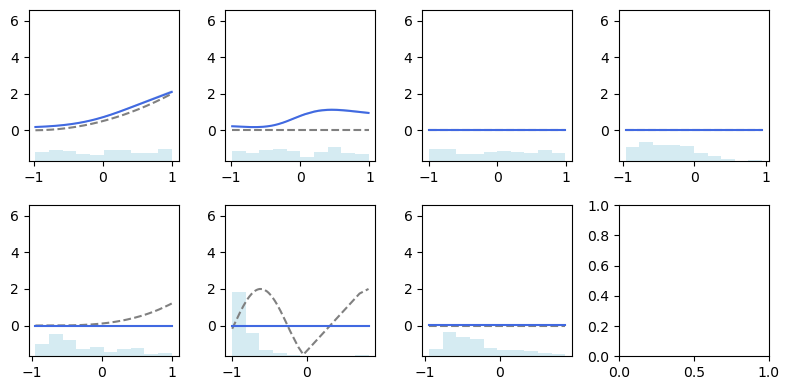

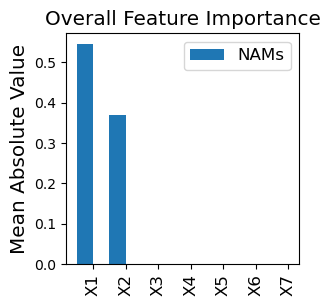

In [10]:
X, y, shape_functions, names = test_samples
prediction_mean, feature_contribution_mean, prediction_mean, feature_contribution_var = get_prediction(lanam, test_samples)
recover_fig = plot_recovered_functions(X, y, shape_functions, feature_contribution_mean, feature_contribution_var.flatten(start_dim=1), center=False)       
importance_fig = plot_feature_importance(lanam, test_samples)

In [ ]:
cfg = defaults()
w_lanam = LaNAM(config=cfg, name="LA-NAM", in_features=in_features, hessian_structure='kron', subset_of_weights='last_layer')
w_lanam, margs, losses, perfs = marglik_training(w_lanam, 
                                                   train_dl, 
                                                   train_dl_fnn, 
                                                   test_dl, 
                                                   likelihood='regression', 
                                                   test_samples=test_samples,
                                                   n_epochs=500, 
                                                   use_wandb=False, 
                                                   optimizer_kwargs={'lr': 1e-2}, 
                                                   concurvity_regularization=0.1, 
                                                  log_loss_frequency=20)
    

In [ ]:
X, y, shape_functions, names = test_samples
prediction_mean, feature_contribution_mean, prediction_mean, feature_contribution_var = get_prediction(w_lanam, test_samples)
recover_fig = plot_recovered_functions(X, y, shape_functions, feature_contribution_mean, feature_contribution_var.flatten(start_dim=1), center=False)       
importance_fig = plot_feature_importance(w_lanam, test_samples)